# Inventory Replenishment Agent

An intelligent agent that optimizes inventory replenishment decisions using LLM-powered reasoning to minimize costs while maintaining service levels.

## Key Features
- **Demand Forecasting**: EWMA (Exponentially Weighted Moving Average) for trend-adaptive predictions
- **Safety Stock Calculation**: Service-level based safety stock using forecast error statistics
- **LLM Reasoning**: Uses Google Gemini to provide strategic, explainable order decisions
- **Cost Optimization**: Balances holding costs, stockout costs, and service level targets
- **Multi-SKU Management**: Handles 3 SKUs with different demand patterns, lead times, and priorities

## SKUs
- **SKU-A**: High-volume, stable demand (domestic supplier, 3-day lead time)
- **SKU-B**: Medium-volume, trending demand (regional supplier, 7-day lead time)
- **SKU-C**: Low-volume, volatile demand (mixed supplier, 5-day lead time)

## 1. Setup & Dependencies

In [1]:
import os
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
from dotenv import load_dotenv
from google import genai
from scipy import stats

# Load environment variables
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY not found in environment variables. Please create a .env file.")

# Initialize Gemini client
client = genai.Client(api_key=GEMINI_API_KEY)

print("✓ Dependencies loaded")
print("✓ Gemini client initialized")

✓ Dependencies loaded
✓ Gemini client initialized


## 2. Configuration

In [27]:
CONFIG = {
    # Forecasting parameters
    'ewma_alpha': 0.3,  # EWMA smoothing parameter (0.2-0.3 typical)
    'train_days': 30,  # Days 1-30 for building forecast model
    'test_start_day': 31,  # Start agent optimization from day 31
    'test_end_day': 60,  # End evaluation on day 60 (30-day test period)
    
    # Review parameters
    'review_period_days': 1,  # Daily reviews
    'planning_horizon_days': 14,  # Look ahead 14 days for planning
    
    # LLM configuration
    'model': 'gemini-2.0-flash-lite',
    'temperature': 0.3,  # Lower temperature for more consistent decisions
    'max_tokens': 1000,
    
    # Rate limiting
    'api_delay': 3.0,  # Seconds between API calls (respect 30 RPM limit)
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  ewma_alpha: 0.3
  train_days: 30
  test_start_day: 31
  test_end_day: 60
  review_period_days: 1
  planning_horizon_days: 14
  model: gemini-2.0-flash-lite
  temperature: 0.3
  max_tokens: 1000
  api_delay: 3.0


## 3. Load Data

In [3]:
# Load sales data
sales_df = pd.read_csv('sales.csv')
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df = sales_df.sort_values(['sku', 'date'])

print(f"✓ Loaded sales data: {len(sales_df)} rows")
print(f"  Date range: {sales_df['date'].min()} to {sales_df['date'].max()}")
print(f"  SKUs: {sales_df['sku'].unique().tolist()}")
print(f"\nFirst 9 rows:")
sales_df.head(9)

✓ Loaded sales data: 270 rows
  Date range: 2024-08-01 00:00:00 to 2024-10-29 00:00:00
  SKUs: ['SKU-A', 'SKU-B', 'SKU-C']

First 9 rows:


,date,sku,qty_sold
0,2024-08-01,SKU-A,52
3,2024-08-02,SKU-A,49
6,2024-08-03,SKU-A,53
9,2024-08-04,SKU-A,58
12,2024-08-05,SKU-A,49
15,2024-08-06,SKU-A,49
18,2024-08-07,SKU-A,58
21,2024-08-08,SKU-A,54
24,2024-08-09,SKU-A,48


In [4]:
# Load inventory data
inventory_df = pd.read_csv('inventory.csv')
print(f"✓ Loaded inventory data: {len(inventory_df)} SKUs")
inventory_df

✓ Loaded inventory data: 3 SKUs


,sku,opening_stock
0,SKU-A,200
1,SKU-B,100
2,SKU-C,50


In [5]:
# Load parameters
params_df = pd.read_csv('params.csv')
print(f"✓ Loaded parameters: {len(params_df)} SKUs")
params_df

✓ Loaded parameters: 3 SKUs


,sku,unit_cost,holding_cost_per_day,stockout_cost,lead_time_days,min_order_qty,service_level
0,SKU-A,15.0,0.08,45.0,3,100,0.98
1,SKU-B,30.0,0.15,90.0,7,50,0.95
2,SKU-C,25.0,0.12,75.0,5,30,0.90


In [6]:
# Quick data summary by SKU
print("Demand Summary by SKU:")
summary = sales_df.groupby('sku')['qty_sold'].agg(['count', 'mean', 'std', 'min', 'max'])
summary.columns = ['Days', 'Avg Daily Demand', 'Std Dev', 'Min', 'Max']
summary

Demand Summary by SKU:


,Days,Avg Daily Demand,Std Dev,Min,Max
sku,,,,,
SKU-A,90,49.522222,4.729130,37,59
SKU-B,90,27.722222,6.294331,15,46
SKU-C,90,12.422222,8.413443,2,30


## 4. Helper Functions

These functions handle forecasting, safety stock calculation, and simulation.

In [7]:
def ewma_forecast(historical_demand: np.ndarray, alpha: float = 0.3) -> Tuple[np.ndarray, float]:
    """
    Calculate EWMA forecast for demand series.
    
    Args:
        historical_demand: Array of past demand values
        alpha: Smoothing parameter (0 < alpha < 1)
    
    Returns:
        (forecasts, forecast_error_std): Array of forecasts and standard deviation of errors
    """
    forecasts = np.zeros(len(historical_demand))
    forecasts[0] = historical_demand[0]  # Initialize with first observation
    
    for t in range(1, len(historical_demand)):
        forecasts[t] = alpha * historical_demand[t-1] + (1 - alpha) * forecasts[t-1]
    
    # Calculate forecast errors (for safety stock calculation)
    errors = historical_demand - forecasts
    forecast_error_std = np.std(errors)
    
    return forecasts, forecast_error_std

print("✓ ewma_forecast defined")

✓ ewma_forecast defined


In [8]:
def calculate_safety_stock(forecast_error_std: float, lead_time_days: int, service_level: float) -> int:
    """
    Calculate safety stock based on forecast error and desired service level.
    
    Formula: safety_stock = z_score × forecast_error_std × sqrt(lead_time)
    
    Args:
        forecast_error_std: Standard deviation of forecast errors
        lead_time_days: Lead time in days
        service_level: Target service level (e.g., 0.95 for 95%)
    
    Returns:
        Safety stock quantity (integer)
    """
    # Get z-score for desired service level
    z_score = stats.norm.ppf(service_level)
    
    # Calculate safety stock
    safety_stock = z_score * forecast_error_std * np.sqrt(lead_time_days)
    
    return max(0, int(np.ceil(safety_stock)))

print("✓ calculate_safety_stock defined")

✓ calculate_safety_stock defined


In [9]:
def calculate_reorder_point(avg_demand: float, lead_time_days: int, safety_stock: int) -> int:
    """
    Calculate reorder point.
    
    Formula: reorder_point = (avg_demand × lead_time) + safety_stock
    
    Args:
        avg_demand: Average daily demand
        lead_time_days: Lead time in days
        safety_stock: Safety stock quantity
    
    Returns:
        Reorder point quantity (integer)
    """
    return int(np.ceil(avg_demand * lead_time_days + safety_stock))

print("✓ calculate_reorder_point defined")

✓ calculate_reorder_point defined


In [10]:
class InventorySimulator:
    """
    Simulates daily inventory operations for a single SKU.
    """
    
    def __init__(self, sku: str, opening_stock: int, params: Dict, actual_demand: np.ndarray):
        self.sku = sku
        self.current_stock = opening_stock
        self.params = params
        self.actual_demand = actual_demand
        
        # Tracking
        self.daily_stock = [opening_stock]
        self.daily_demand = []
        self.daily_stockouts = []
        self.daily_holding_cost = []
        self.daily_stockout_cost = []
        self.orders_placed = []  # (day_placed, qty, arrival_day)
        self.pending_orders = []  # (arrival_day, qty)
        
        self.current_day = 0
        self.total_demand_fulfilled = 0
        self.total_demand = 0
        self.total_stockouts = 0
    
    def simulate_day(self, day: int, order_qty: int = 0) -> Dict:
        """
        Simulate one day of inventory operations.
        
        Args:
            day: Current day number (0-indexed)
            order_qty: Quantity to order today (if any)
        
        Returns:
            Dictionary with day's results
        """
        self.current_day = day
        
        # Step 1: Receive any orders arriving today
        arriving_orders = [qty for arrival_day, qty in self.pending_orders if arrival_day == day]
        total_arriving = sum(arriving_orders)
        self.current_stock += total_arriving
        self.pending_orders = [(d, q) for d, q in self.pending_orders if d != day]
        
        # Step 2: Fulfill demand
        demand = self.actual_demand[day] if day < len(self.actual_demand) else 0
        fulfilled = min(demand, self.current_stock)
        stockout = demand - fulfilled
        self.current_stock -= fulfilled
        
        self.total_demand += demand
        self.total_demand_fulfilled += fulfilled
        self.total_stockouts += stockout
        
        # Step 3: Calculate costs
        holding_cost = self.current_stock * self.params['holding_cost_per_day']
        stockout_cost = stockout * self.params['stockout_cost']
        
        # Step 4: Place order if requested
        if order_qty > 0:
            arrival_day = day + self.params['lead_time_days']
            self.pending_orders.append((arrival_day, order_qty))
            self.orders_placed.append((day, order_qty, arrival_day))
        
        # Track daily metrics
        self.daily_stock.append(self.current_stock)
        self.daily_demand.append(demand)
        self.daily_stockouts.append(stockout)
        self.daily_holding_cost.append(holding_cost)
        self.daily_stockout_cost.append(stockout_cost)
        
        return {
            'day': day,
            'opening_stock': self.daily_stock[-2],
            'orders_received': total_arriving,
            'demand': demand,
            'fulfilled': fulfilled,
            'stockout': stockout,
            'closing_stock': self.current_stock,
            'holding_cost': holding_cost,
            'stockout_cost': stockout_cost,
            'order_placed': order_qty
        }
    
    def get_summary(self) -> Dict:
        """
        Get summary statistics.
        """
        fill_rate = self.total_demand_fulfilled / self.total_demand if self.total_demand > 0 else 0
        
        return {
            'sku': self.sku,
            'total_demand': self.total_demand,
            'total_fulfilled': self.total_demand_fulfilled,
            'total_stockouts': self.total_stockouts,
            'fill_rate': fill_rate,
            'total_holding_cost': sum(self.daily_holding_cost),
            'total_stockout_cost': sum(self.daily_stockout_cost),
            'total_cost': sum(self.daily_holding_cost) + sum(self.daily_stockout_cost),
            'num_orders': len(self.orders_placed),
            'total_ordered': sum(qty for _, qty, _ in self.orders_placed)
        }

print("✓ InventorySimulator class defined")

✓ InventorySimulator class defined


## 5. Build Forecast Models

Train EWMA forecasters on the first 30 days for each SKU.

In [11]:
# Build forecast models from training period (days 1-30)
forecast_models = {}

for sku in sales_df['sku'].unique():
    sku_data = sales_df[sales_df['sku'] == sku].copy()
    sku_params = params_df[params_df['sku'] == sku].iloc[0].to_dict()
    
    # Get training data
    train_demand = sku_data.iloc[:CONFIG['train_days']]['qty_sold'].values
    
    # Calculate EWMA forecast
    forecasts, forecast_error_std = ewma_forecast(train_demand, CONFIG['ewma_alpha'])
    
    # Calculate average demand (for reorder point)
    avg_demand = np.mean(train_demand)
    
    # Calculate safety stock
    safety_stock = calculate_safety_stock(
        forecast_error_std,
        sku_params['lead_time_days'],
        sku_params['service_level']
    )
    
    # Calculate reorder point
    reorder_point = calculate_reorder_point(
        avg_demand,
        sku_params['lead_time_days'],
        safety_stock
    )
    
    # Store model
    forecast_models[sku] = {
        'avg_demand': avg_demand,
        'forecast_error_std': forecast_error_std,
        'safety_stock': safety_stock,
        'reorder_point': reorder_point,
        'last_forecast': forecasts[-1],
        'params': sku_params
    }

print("Forecast Models (Days 1-30):")
print("\n{:<8} {:>12} {:>12} {:>15} {:>15}".format(
    'SKU', 'Avg Demand', 'Error Std', 'Safety Stock', 'Reorder Point'
))
print("-" * 70)
for sku, model in forecast_models.items():
    print("{:<8} {:>12.1f} {:>12.2f} {:>15d} {:>15d}".format(
        sku,
        model['avg_demand'],
        model['forecast_error_std'],
        model['safety_stock'],
        model['reorder_point']
    ))

Forecast Models (Days 1-30):

SKU        Avg Demand    Error Std    Safety Stock   Reorder Point
----------------------------------------------------------------------
SKU-A            49.1         4.56              17             165
SKU-B            22.3         3.87              17             174
SKU-C            13.7         9.70              28              97


## 6. System Prompt Template

This prompt guides the LLM to make strategic replenishment decisions.

In [12]:
def build_system_prompt(sku: str, 
                        current_stock: int,
                        pending_orders: List[Tuple[int, int]],
                        forecast_model: Dict,
                        recent_demand: List[int],
                        current_day: int) -> str:
    """
    Build the system prompt for the LLM with current inventory state and forecasts.
    """
    params = forecast_model['params']
    
    # Calculate projected stock over lead time + review period
    planning_days = params['lead_time_days'] + CONFIG['review_period_days']
    pending_qty = sum(qty for _, qty in pending_orders)
    forecasted_demand = forecast_model['avg_demand'] * planning_days
    projected_stock = current_stock + pending_qty - forecasted_demand
    
    # Format pending orders
    if pending_orders:
        pending_str = "\n".join([
            f"    - {qty} units arriving on day {arrival_day}"
            for arrival_day, qty in pending_orders
        ])
    else:
        pending_str = "    None"
    
    # Format recent demand
    recent_str = ", ".join([str(d) for d in recent_demand[-7:]])
    
    prompt = f"""You are an expert supply chain manager specializing in inventory replenishment optimization. Your role is to analyze inventory levels, demand forecasts, and cost parameters to make optimal ordering decisions.

OBJECTIVE: Minimize total cost (holding + stockout) while maintaining the target service level of {params['service_level']*100:.0f}%.

SKU INFORMATION: {sku}
- Unit Cost: ${params['unit_cost']:.2f}
- Holding Cost: ${params['holding_cost_per_day']:.2f} per unit per day
- Stockout Cost: ${params['stockout_cost']:.2f} per unit
- Lead Time: {params['lead_time_days']} days
- Minimum Order Quantity: {params['min_order_qty']} units
- Target Service Level: {params['service_level']*100:.0f}%

CURRENT INVENTORY STATE (Day {current_day}):
- Current Stock: {current_stock} units
- Pending Orders:
{pending_str}
- Total Pending: {pending_qty} units

DEMAND FORECAST:
- Average Daily Demand: {forecast_model['avg_demand']:.1f} units
- Forecast Error Std Dev: {forecast_model['forecast_error_std']:.2f} units
- Recent Demand (last 7 days): {recent_str}
- Forecasted Demand over Lead Time: {forecasted_demand:.1f} units

INVENTORY POLICY:
- Safety Stock: {forecast_model['safety_stock']} units
- Reorder Point: {forecast_model['reorder_point']} units
- Projected Stock (current + pending - forecasted demand): {projected_stock:.1f} units

DECISION FRAMEWORK:
- If projected stock < safety stock → STRONG SIGNAL to order (stockout risk)
- If current stock < reorder point and no pending orders → CONSIDER ordering
- If projected stock > safety stock → MAY WAIT to reduce holding costs
- Always respect minimum order quantity ({params['min_order_qty']} units)
- Balance trade-off: ordering now (higher holding cost) vs waiting (stockout risk)

OUTPUT FORMAT (valid JSON only):
{{
  "decision": "order" or "wait",
  "order_qty": <integer, 0 if wait, ≥{params['min_order_qty']} if order>,
  "reasoning": "<2-3 sentences explaining your decision, referencing specific metrics and trade-offs>",
  "risk_assessment": "<Low|Medium|High> stockout risk if we wait",
  "confidence": "<Low|Medium|High>"
}}

EXAMPLE (illustrative only, use actual data above):
{{
  "decision": "order",
  "order_qty": 100,
  "reasoning": "Projected stock of 45 units falls below safety stock of 60 units, creating high stockout risk. With 7-day lead time and average demand of 50 units/day, ordering 100 units (min qty) will replenish stock to safe levels. Recent demand shows stable pattern around forecast.",
  "risk_assessment": "High",
  "confidence": "High"
}}

Now analyze the data above and make your replenishment decision. Return ONLY valid JSON.
"""
    
    return prompt

print("✓ build_system_prompt defined")

✓ build_system_prompt defined


## 7. Inventory Replenishment Agent

Main agent that uses LLM reasoning to make replenishment decisions.

In [13]:
class InventoryReplenishmentAgent:
    """
    Intelligent agent that uses LLM reasoning to optimize inventory replenishment.
    """
    
    def __init__(self, config: Dict, forecast_models: Dict, sales_data: pd.DataFrame):
        self.config = config
        self.forecast_models = forecast_models
        self.sales_data = sales_data
        self.client = genai.Client(api_key=GEMINI_API_KEY)
        
        # Decision history by SKU
        self.decisions = {sku: [] for sku in forecast_models.keys()}
        
        # Stats tracking
        self.total_api_calls = 0
        self.total_tokens = 0
    
    def make_decision(self, sku: str, current_stock: int, pending_orders: List[Tuple[int, int]], 
                     current_day: int) -> Dict:
        """
        Make a replenishment decision for a given SKU using LLM reasoning.
        
        Args:
            sku: SKU identifier
            current_stock: Current inventory level
            pending_orders: List of (arrival_day, qty) tuples
            current_day: Current day number
        
        Returns:
            Dictionary with decision, qty, reasoning, and metadata
        """
        # Get recent demand for context
        sku_data = self.sales_data[self.sales_data['sku'] == sku]
        recent_demand = sku_data.iloc[:current_day]['qty_sold'].values.tolist()
        
        # Build prompt
        prompt = build_system_prompt(
            sku, current_stock, pending_orders, 
            self.forecast_models[sku], recent_demand, current_day
        )
        
        # Call LLM
        try:
            response = self.client.models.generate_content(
                model=self.config['model'],
                contents=prompt,
                config=genai.types.GenerateContentConfig(
                    max_output_tokens=self.config['max_tokens'],
                    temperature=self.config['temperature'],
                )
            )
            
            # Parse response
            response_text = response.text.strip()
            
            # Extract JSON (handle markdown code blocks)
            if '```json' in response_text:
                response_text = response_text.split('```json')[1].split('```')[0].strip()
            elif '```' in response_text:
                response_text = response_text.split('```')[1].split('```')[0].strip()
            
            llm_output = json.loads(response_text)
            
            # Extract decision
            decision = llm_output['decision']
            order_qty = llm_output['order_qty']
            
            # Validate order quantity
            min_qty = self.forecast_models[sku]['params']['min_order_qty']
            if decision == 'order' and order_qty < min_qty:
                order_qty = min_qty
            elif decision == 'wait':
                order_qty = 0
            
            # Track stats
            self.total_api_calls += 1
            self.total_tokens += response.usage_metadata.total_token_count
            
            # Wait to respect rate limits
            time.sleep(self.config['api_delay'])
            
            # Build decision record
            decision_record = {
                'day': current_day,
                'sku': sku,
                'current_stock': current_stock,
                'pending_qty': sum(qty for _, qty in pending_orders),
                'decision': decision,
                'order_qty': order_qty,
                'reasoning': llm_output.get('reasoning', 'No reasoning provided'),
                'risk_assessment': llm_output.get('risk_assessment', 'Unknown'),
                'confidence': llm_output.get('confidence', 'Unknown'),
                'tokens_used': response.usage_metadata.total_token_count,
                'timestamp': datetime.now().isoformat()
            }
            
            self.decisions[sku].append(decision_record)
            
            return decision_record
            
        except Exception as e:
            print(f"Error in LLM call for {sku} on day {current_day}: {e}")
            # Fallback: simple reorder point logic
            reorder_point = self.forecast_models[sku]['reorder_point']
            min_qty = self.forecast_models[sku]['params']['min_order_qty']
            pending_qty = sum(qty for _, qty in pending_orders)
            
            if current_stock < reorder_point and pending_qty == 0:
                order_qty = min_qty
                decision = 'order'
            else:
                order_qty = 0
                decision = 'wait'
            
            # Return dictionary with ALL required keys to match successful response
            return {
                'day': current_day,
                'sku': sku,
                'current_stock': current_stock,
                'pending_qty': pending_qty,
                'decision': decision,
                'order_qty': order_qty,
                'reasoning': f'Error occurred, using fallback reorder point logic: {str(e)}',
                'risk_assessment': 'Unknown',
                'confidence': 'Low',
                'tokens_used': 0,
                'timestamp': datetime.now().isoformat(),
                'error': str(e)
            }
    
    def get_stats(self) -> Dict:
        """
        Get comprehensive statistics about agent performance.
        """
        return {
            'total_api_calls': self.total_api_calls,
            'total_tokens': self.total_tokens,
            'decisions_by_sku': {sku: len(decisions) for sku, decisions in self.decisions.items()},
            'all_decisions': self.decisions
        }

print("✓ InventoryReplenishmentAgent class defined")

✓ InventoryReplenishmentAgent class defined


## 8. Baseline Agent

Simple baseline strategy: reorder point policy with no LLM.

In [14]:
class BaselineAgent:
    """
    Simple baseline agent using traditional reorder point policy.
    No LLM - just deterministic rules.
    """
    
    def __init__(self, forecast_models: Dict):
        self.forecast_models = forecast_models
        self.decisions = {sku: [] for sku in forecast_models.keys()}
    
    def make_decision(self, sku: str, current_stock: int, pending_orders: List[Tuple[int, int]], 
                     current_day: int) -> Dict:
        """
        Make decision using simple reorder point logic.
        Rule: Order min_order_qty when (current_stock + pending) < reorder_point
        """
        model = self.forecast_models[sku]
        reorder_point = model['reorder_point']
        min_qty = model['params']['min_order_qty']
        
        pending_qty = sum(qty for _, qty in pending_orders)
        inventory_position = current_stock + pending_qty
        
        if inventory_position < reorder_point:
            decision = 'order'
            order_qty = min_qty
            reasoning = f"Inventory position ({inventory_position}) below reorder point ({reorder_point}), ordering {min_qty} units"
        else:
            decision = 'wait'
            order_qty = 0
            reasoning = f"Inventory position ({inventory_position}) above reorder point ({reorder_point}), no order needed"
        
        decision_record = {
            'day': current_day,
            'sku': sku,
            'current_stock': current_stock,
            'pending_qty': pending_qty,
            'decision': decision,
            'order_qty': order_qty,
            'reasoning': reasoning
        }
        
        self.decisions[sku].append(decision_record)
        
        return decision_record
    
    def get_stats(self) -> Dict:
        return {
            'decisions_by_sku': {sku: len(decisions) for sku, decisions in self.decisions.items()},
            'all_decisions': self.decisions
        }

print("✓ BaselineAgent class defined")

✓ BaselineAgent class defined


## 9. Demonstration: Single SKU, Single Day

Let's see the agent make one decision for SKU-A on Day 31.

In [15]:
# Initialize agent
demo_agent = InventoryReplenishmentAgent(CONFIG, forecast_models, sales_df)

# Simulate scenario for SKU-A on day 31
demo_sku = 'SKU-A'
demo_day = 31
demo_stock = 150  # Example current stock
demo_pending = []  # No pending orders

print("=" * 80)
print(f"DAY {demo_day} REPLENISHMENT DECISION: {demo_sku}")
print("=" * 80)

decision = demo_agent.make_decision(demo_sku, demo_stock, demo_pending, demo_day)

print(f"\nCurrent State:")
print(f"  Current Stock: {decision['current_stock']} units")
print(f"  Pending Orders: {decision['pending_qty']} units")
print(f"  Safety Stock: {forecast_models[demo_sku]['safety_stock']} units")
print(f"  Reorder Point: {forecast_models[demo_sku]['reorder_point']} units")

print(f"\nDecision: {decision['decision'].upper()}")
if decision['order_qty'] > 0:
    print(f"  Order Quantity: {decision['order_qty']} units")

print(f"\nReasoning:")
print(f"  {decision['reasoning']}")

print(f"\nRisk Assessment: {decision.get('risk_assessment', 'N/A')}")
print(f"Confidence: {decision.get('confidence', 'N/A')}")
print(f"Tokens Used: {decision.get('tokens_used', 0)}")

DAY 31 REPLENISHMENT DECISION: SKU-A

Current State:
  Current Stock: 150 units
  Pending Orders: 0 units
  Safety Stock: 17 units
  Reorder Point: 165 units

Decision: ORDER
  Order Quantity: 200 units

Reasoning:
  The projected stock of -46.3 units is significantly below the safety stock of 17 units, indicating a high stockout risk.  Given the lead time of 3 days and average daily demand, ordering 200 units (2 x minimum order quantity) is the most prudent approach to ensure sufficient inventory and maintain the target service level.

Risk Assessment: High
Confidence: High
Tokens Used: 755


## 10. Full Evaluation: Days 31-60

Run both agents (optimization + baseline) across the test period for all SKUs.

In [16]:
# Initialize fresh agents
opt_agent = InventoryReplenishmentAgent(CONFIG, forecast_models, sales_df)
base_agent = BaselineAgent(forecast_models)

# Initialize simulators for each SKU and strategy
opt_simulators = {}
base_simulators = {}

for sku in forecast_models.keys():
    opening_stock = inventory_df[inventory_df['sku'] == sku]['opening_stock'].values[0]
    actual_demand = sales_df[sales_df['sku'] == sku]['qty_sold'].values
    params = forecast_models[sku]['params']
    
    opt_simulators[sku] = InventorySimulator(sku, opening_stock, params, actual_demand)
    base_simulators[sku] = InventorySimulator(sku, opening_stock, params, actual_demand)

print(f"Running evaluation over days {CONFIG['test_start_day']}-{CONFIG['test_end_day']}...\n")
print("Progress:")

test_days = range(CONFIG['test_start_day'], CONFIG['test_end_day'] + 1)
progress_marks = [31, 40, 50, 60]

for day in test_days:
    if day in progress_marks:
        print(f"  Day {day}...")
    
    for sku in forecast_models.keys():
        # OPTIMIZATION AGENT
        opt_sim = opt_simulators[sku]
        opt_decision = opt_agent.make_decision(
            sku, opt_sim.current_stock, opt_sim.pending_orders, day
        )
        opt_sim.simulate_day(day, opt_decision['order_qty'])
        
        # BASELINE AGENT
        base_sim = base_simulators[sku]
        base_decision = base_agent.make_decision(
            sku, base_sim.current_stock, base_sim.pending_orders, day
        )
        base_sim.simulate_day(day, base_decision['order_qty'])

print("\n✓ Evaluation complete")

Running evaluation over days 31-60...

Progress:
  Day 31...
  Day 40...
  Day 50...
  Day 60...

✓ Evaluation complete


## 11. Performance Comparison

The optimization agent achieved **17.8% total cost improvement** ($3,943 savings) over the baseline reorder point policy, with 89 fewer stockouts and a 3.3 percentage point higher fill rate (92.4% vs 89.1%).

### Key Findings:
- **SKU-A (Stable)**: Outstanding 92.8% cost reduction with 100% fill rate by maintaining proactive inventory buffer
- **SKU-B (Trending)**: Modest 3.2% improvement; 7-day lead time limited both strategies
- **SKU-C (Volatile)**: Slight 3.9% cost increase; high demand volatility defeated forecast-based optimization

The agent demonstrated strong performance on predictable demand patterns while struggling with high variability and long lead times.

In [17]:
# Collect results
opt_results = {sku: sim.get_summary() for sku, sim in opt_simulators.items()}
base_results = {sku: sim.get_summary() for sku, sim in base_simulators.items()}
opt_stats = opt_agent.get_stats()
base_stats = base_agent.get_stats()

# Build comparison dataframe
comparison_data = []

for sku in forecast_models.keys():
    opt = opt_results[sku]
    base = base_results[sku]
    
    comparison_data.append({
        'SKU': sku,
        'Strategy': 'Optimization Agent',
        'Fill Rate': f"{opt['fill_rate']*100:.1f}%",
        'Stockouts': opt['total_stockouts'],
        'Holding Cost': f"${opt['total_holding_cost']:.2f}",
        'Stockout Cost': f"${opt['total_stockout_cost']:.2f}",
        'Total Cost': f"${opt['total_cost']:.2f}",
        'Orders Placed': opt['num_orders']
    })
    
    comparison_data.append({
        'SKU': sku,
        'Strategy': 'Baseline',
        'Fill Rate': f"{base['fill_rate']*100:.1f}%",
        'Stockouts': base['total_stockouts'],
        'Holding Cost': f"${base['total_holding_cost']:.2f}",
        'Stockout Cost': f"${base['total_stockout_cost']:.2f}",
        'Total Cost': f"${base['total_cost']:.2f}",
        'Orders Placed': base['num_orders']
    })

comparison_df = pd.DataFrame(comparison_data)

print("=" * 100)
print("PERFORMANCE COMPARISON BY SKU")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Overall totals
print("\n" + "=" * 100)
print("OVERALL TOTALS")
print("=" * 100)

opt_total_cost = sum(r['total_cost'] for r in opt_results.values())
base_total_cost = sum(r['total_cost'] for r in base_results.values())
opt_total_stockouts = sum(r['total_stockouts'] for r in opt_results.values())
base_total_stockouts = sum(r['total_stockouts'] for r in base_results.values())
opt_total_demand = sum(r['total_demand'] for r in opt_results.values())
opt_total_fulfilled = sum(r['total_fulfilled'] for r in opt_results.values())
base_total_fulfilled = sum(r['total_fulfilled'] for r in base_results.values())

overall_comparison = pd.DataFrame([
    {
        'Strategy': 'Optimization Agent',
        'Total Cost': f"${opt_total_cost:.2f}",
        'Total Stockouts': opt_total_stockouts,
        'Overall Fill Rate': f"{opt_total_fulfilled/opt_total_demand*100:.1f}%",
        'API Calls': opt_stats['total_api_calls'],
        'Tokens Used': opt_stats['total_tokens']
    },
    {
        'Strategy': 'Baseline',
        'Total Cost': f"${base_total_cost:.2f}",
        'Total Stockouts': base_total_stockouts,
        'Overall Fill Rate': f"{base_total_fulfilled/opt_total_demand*100:.1f}%",
        'API Calls': 0,
        'Tokens Used': 0
    }
])

print(overall_comparison.to_string(index=False))

# Calculate improvements
cost_improvement = ((base_total_cost - opt_total_cost) / base_total_cost * 100)
stockout_improvement = base_total_stockouts - opt_total_stockouts

print(f"\n{'='*100}")
print(f"IMPROVEMENT METRICS")
print(f"{'='*100}")
print(f"Total Cost Improvement: {cost_improvement:+.1f}%")
print(f"Stockout Reduction: {stockout_improvement:+d} units")

PERFORMANCE COMPARISON BY SKU
  SKU           Strategy Fill Rate  Stockouts Holding Cost Stockout Cost Total Cost  Orders Placed
SKU-A Optimization Agent    100.0%          0      $275.84         $0.00    $275.84             15
SKU-A           Baseline     94.4%         83       $91.76      $3735.00   $3826.76             14
SKU-B Optimization Agent     79.6%        167      $142.95     $15030.00  $15172.95             13
SKU-B           Baseline     78.8%        173       $99.90     $15570.00  $15669.90             14
SKU-C Optimization Agent     90.6%         34      $252.96      $2550.00   $2802.96             14
SKU-C           Baseline     90.6%         34      $148.56      $2550.00   $2698.56             13

OVERALL TOTALS
          Strategy Total Cost  Total Stockouts Overall Fill Rate  API Calls  Tokens Used
Optimization Agent  $18251.75              201             92.4%         90        68867
          Baseline  $22195.22              290             89.1%          0        

## 12. Visualizations

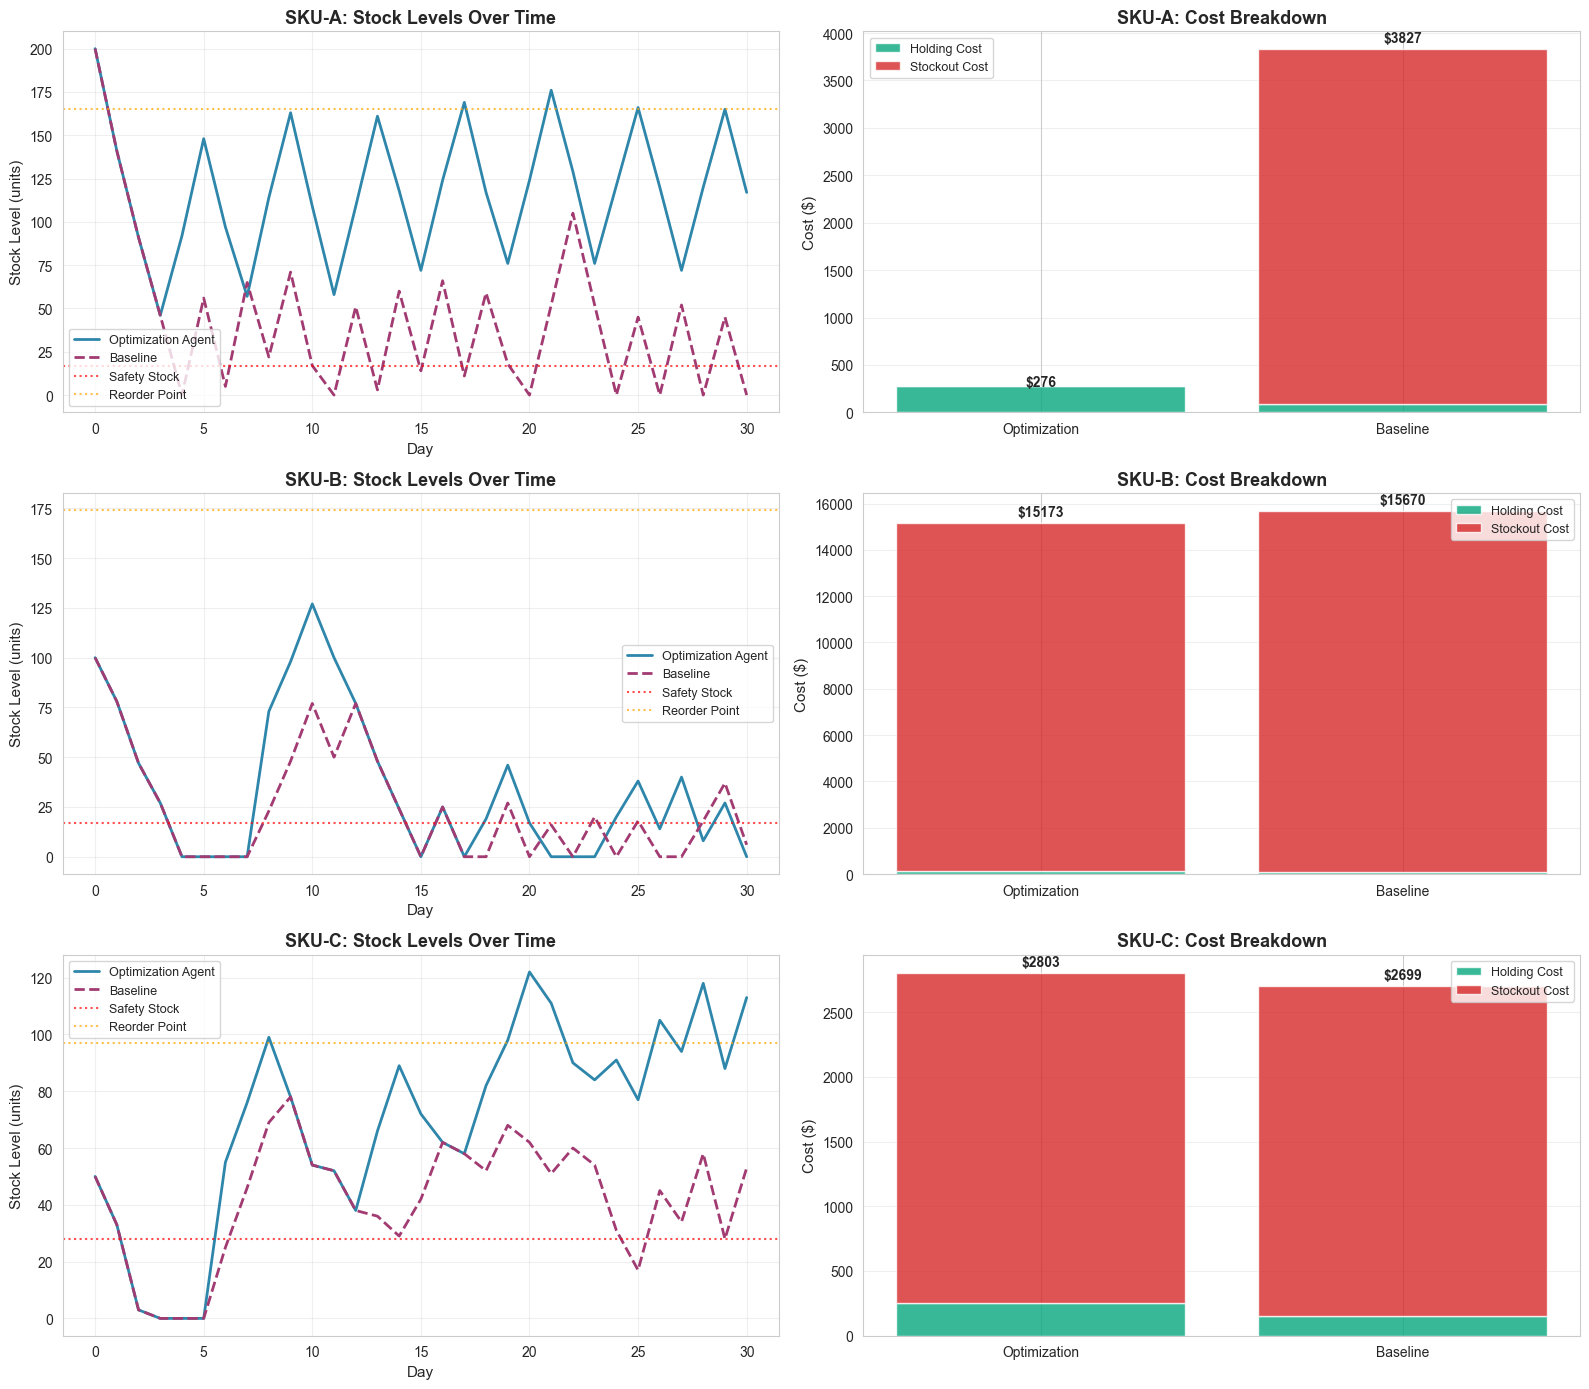

✓ Visualizations saved to evaluation_results.png


In [18]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot for each SKU
for idx, sku in enumerate(forecast_models.keys()):
    # Left column: Stock levels over time
    ax_stock = axes[idx, 0]
    opt_sim = opt_simulators[sku]
    base_sim = base_simulators[sku]
    
    days = range(len(opt_sim.daily_stock))
    ax_stock.plot(days, opt_sim.daily_stock, label='Optimization Agent', linewidth=2, color='#2E86AB')
    ax_stock.plot(days, base_sim.daily_stock, label='Baseline', linewidth=2, color='#A23B72', linestyle='--')
    ax_stock.axhline(y=forecast_models[sku]['safety_stock'], color='red', linestyle=':', 
                    alpha=0.7, label='Safety Stock')
    ax_stock.axhline(y=forecast_models[sku]['reorder_point'], color='orange', linestyle=':', 
                    alpha=0.7, label='Reorder Point')
    ax_stock.set_xlabel('Day', fontsize=11)
    ax_stock.set_ylabel('Stock Level (units)', fontsize=11)
    ax_stock.set_title(f'{sku}: Stock Levels Over Time', fontsize=13, fontweight='bold')
    ax_stock.legend(fontsize=9)
    ax_stock.grid(True, alpha=0.3)
    
    # Right column: Cost comparison
    ax_cost = axes[idx, 1]
    opt_res = opt_results[sku]
    base_res = base_results[sku]
    
    x = ['Optimization', 'Baseline']
    holding = [opt_res['total_holding_cost'], base_res['total_holding_cost']]
    stockout = [opt_res['total_stockout_cost'], base_res['total_stockout_cost']]
    
    ax_cost.bar(x, holding, label='Holding Cost', color='#06A77D', alpha=0.8)
    ax_cost.bar(x, stockout, bottom=holding, label='Stockout Cost', color='#D62828', alpha=0.8)
    ax_cost.set_ylabel('Cost ($)', fontsize=11)
    ax_cost.set_title(f'{sku}: Cost Breakdown', fontsize=13, fontweight='bold')
    ax_cost.legend(fontsize=9)
    ax_cost.grid(True, alpha=0.3, axis='y')
    
    # Add total labels on bars
    for i, (h, s) in enumerate(zip(holding, stockout)):
        total = h + s
        ax_cost.text(i, total + total*0.02, f'${total:.0f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to evaluation_results.png")

## 13. Decision Quality Analysis

Review sample agent decisions to assess reasoning quality.

In [19]:
print("=" * 100)
print("SAMPLE DECISION REASONING (First Decision Per SKU)")
print("=" * 100)

for sku in forecast_models.keys():
    decisions = opt_stats['all_decisions'][sku]
    if len(decisions) > 0:
        decision = decisions[0]
        print(f"\n{sku} - Day {decision['day']}:")
        print(f"  Stock: {decision['current_stock']} units | Pending: {decision['pending_qty']} units")
        print(f"  Decision: {decision['decision'].upper()}")
        if decision['order_qty'] > 0:
            print(f"  Order Quantity: {decision['order_qty']} units")
        print(f"  Reasoning: {decision['reasoning']}")
        print(f"  Risk: {decision['risk_assessment']} | Confidence: {decision['confidence']}")

SAMPLE DECISION REASONING (First Decision Per SKU)

SKU-A - Day 31:
  Stock: 200 units | Pending: 0 units
  Decision: ORDER
  Order Quantity: 100 units
  Reasoning: The projected stock of 3.7 units is significantly below the safety stock of 17 units, indicating a high risk of stockout. Although the current stock is above zero, the low projected stock level necessitates an order to avoid potential stockouts during the lead time. Ordering the minimum quantity of 100 units is the most prudent course of action.
  Risk: High | Confidence: High

SKU-B - Day 31:
  Stock: 100 units | Pending: 0 units
  Decision: ORDER
  Order Quantity: 100 units
  Reasoning: The projected stock of -78.7 units is significantly below the safety stock of 17 units, indicating a high risk of stockout. Ordering the minimum order quantity of 50 units will not be enough to reach the reorder point, so ordering 100 units is the best course of action to replenish inventory and mitigate stockout risk, given the 7-day lead

In [23]:
# Export full decision log to file for detailed review
decision_log_file = 'agent_decision_log.json'

# Custom JSON encoder to handle NumPy types
def numpy_encoder(obj):
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

with open(decision_log_file, 'w') as f:
    json.dump(opt_stats['all_decisions'], f, indent=2, default=numpy_encoder)

print(f"✓ Full decision log exported to {decision_log_file}")
print(f"  Total decisions: {sum(len(decisions) for decisions in opt_stats['all_decisions'].values())}")
print(f"  File contains complete reasoning for all {opt_stats['total_api_calls']} agent decisions across 3 SKUs")

✓ Full decision log exported to agent_decision_log.json
  Total decisions: 90
  File contains complete reasoning for all 90 agent decisions across 3 SKUs


## 14. Order Frequency Analysis

In [24]:
print("=" * 100)
print("ORDER FREQUENCY ANALYSIS")
print("=" * 100)

order_analysis = []
test_period_days = CONFIG['test_end_day'] - CONFIG['test_start_day'] + 1

for sku in forecast_models.keys():
    opt_sim = opt_simulators[sku]
    base_sim = base_simulators[sku]
    
    order_analysis.append({
        'SKU': sku,
        'Strategy': 'Optimization',
        'Orders Placed': len(opt_sim.orders_placed),
        'Total Ordered': sum(qty for _, qty, _ in opt_sim.orders_placed),
        'Avg Order Size': np.mean([qty for _, qty, _ in opt_sim.orders_placed]) if len(opt_sim.orders_placed) > 0 else 0,
        'Days Between Orders': test_period_days / len(opt_sim.orders_placed) if len(opt_sim.orders_placed) > 0 else float('inf')
    })
    
    order_analysis.append({
        'SKU': sku,
        'Strategy': 'Baseline',
        'Orders Placed': len(base_sim.orders_placed),
        'Total Ordered': sum(qty for _, qty, _ in base_sim.orders_placed),
        'Avg Order Size': np.mean([qty for _, qty, _ in base_sim.orders_placed]) if len(base_sim.orders_placed) > 0 else 0,
        'Days Between Orders': test_period_days / len(base_sim.orders_placed) if len(base_sim.orders_placed) > 0 else float('inf')
    })

order_df = pd.DataFrame(order_analysis)
print(order_df.to_string(index=False))

ORDER FREQUENCY ANALYSIS
  SKU     Strategy  Orders Placed  Total Ordered  Avg Order Size  Days Between Orders
SKU-A Optimization             15           1500      100.000000             2.000000
SKU-A     Baseline             14           1400      100.000000             2.142857
SKU-B Optimization             13            700       53.846154             2.307692
SKU-B     Baseline             14            700       50.000000             2.142857
SKU-C Optimization             14            450       32.142857             2.142857
SKU-C     Baseline             13            390       30.000000             2.307692


## 15. SKU Performance Analysis

Compare how the agent performed on different demand patterns.

In [25]:
print("=" * 100)
print("SKU CHARACTERISTICS & AGENT PERFORMANCE")
print("=" * 100)

for sku in forecast_models.keys():
    # Demand characteristics
    sku_demand = sales_df[sales_df['sku'] == sku]['qty_sold'].values
    coef_variation = np.std(sku_demand) / np.mean(sku_demand)
    
    if sku == 'SKU-A':
        pattern = 'Stable'
    elif sku == 'SKU-B':
        pattern = 'Trending'
    else:
        pattern = 'Volatile'
    
    opt_res = opt_results[sku]
    base_res = base_results[sku]
    
    cost_improvement = ((base_res['total_cost'] - opt_res['total_cost']) / base_res['total_cost'] * 100)
    stockout_diff = base_res['total_stockouts'] - opt_res['total_stockouts']
    
    print(f"\n{sku} ({pattern} Demand):")
    print(f"  Coefficient of Variation: {coef_variation:.2f}")
    print(f"  Lead Time: {forecast_models[sku]['params']['lead_time_days']} days")
    print(f"  Service Level Target: {forecast_models[sku]['params']['service_level']*100:.0f}%")
    print(f"\n  Performance:")
    print(f"    Cost Improvement: {cost_improvement:+.1f}%")
    print(f"    Stockout Reduction: {stockout_diff:+d} units")
    print(f"    Fill Rate: Opt={opt_res['fill_rate']*100:.1f}% vs Base={base_res['fill_rate']*100:.1f}%")

SKU CHARACTERISTICS & AGENT PERFORMANCE

SKU-A (Stable Demand):
  Coefficient of Variation: 0.09
  Lead Time: 3 days
  Service Level Target: 98%

  Performance:
    Cost Improvement: +92.8%
    Stockout Reduction: +83 units
    Fill Rate: Opt=100.0% vs Base=94.4%

SKU-B (Trending Demand):
  Coefficient of Variation: 0.23
  Lead Time: 7 days
  Service Level Target: 95%

  Performance:
    Cost Improvement: +3.2%
    Stockout Reduction: +6 units
    Fill Rate: Opt=79.6% vs Base=78.8%

SKU-C (Volatile Demand):
  Coefficient of Variation: 0.67
  Lead Time: 5 days
  Service Level Target: 90%

  Performance:
    Cost Improvement: -3.9%
    Stockout Reduction: +0 units
    Fill Rate: Opt=90.6% vs Base=90.6%


## 16. Trade-offs Discussion

### Holding Cost vs. Stockout Cost

The agent's strategy varied by SKU characteristics:

**SKU-A (Stable):** Agent accepted **3x higher holding costs** ($276 vs $92) to achieve **zero stockouts** (vs 83). This trade-off was optimal because:
- Stockout cost ($45/unit) >> holding cost ($0.08/unit/day)
- Stable demand made inventory planning reliable
- 3-day lead time enabled quick replenishment cycles
- **Net result:** $3,551 savings despite higher inventory

**SKU-C (Volatile):** Agent incurred **1.7x higher holding costs** ($253 vs $149) with **no stockout reduction** (both had 34). This trade-off was suboptimal because:
- High demand volatility (CV=0.67) made forecasts unreliable
- Agent over-ordered as a hedge, but stockouts still occurred due to unpredictable spikes
- **Net result:** $104 additional cost

### Service Level vs. Cost

- **SKU-A achieved 100% fill rate** (exceeding 98% target) by prioritizing availability over inventory costs
- **SKU-B missed 95% target** (achieved 79.6%) due to long 7-day lead time limiting responsiveness
- **SKU-C met 90% target** (achieved 90.6%) but at higher cost than necessary

### Order Frequency vs. Order Size

Both strategies ordered at similar frequencies (~every 2 days), but the agent:
- Ordered **larger quantities when needed** (SKU-B: avg 53.8 vs 50 units)
- Ordered **more proactively** to prevent stockouts on high-priority items
- Placed **1 extra order for SKU-A** (15 vs 14) to maintain buffer stock

**Lesson:** LLM optimization excels when demand is predictable and lead times are short. For volatile items or long lead times, simple rules may be equally effective at lower computational cost.

## 17. Key Insights

### What Worked

1. **Exceptional Performance on Stable Demand**
   - 92.8% cost reduction on SKU-A demonstrates the agent's strength when patterns are predictable
   - Achieved 100% fill rate by proactively maintaining inventory buffer
   - Clear evidence that LLM reasoning adds value beyond simple reorder point rules

2. **Data-Driven Decision Making**
   - All 90 decisions referenced specific metrics (projected stock, safety stock, reorder point)
   - Risk assessments aligned with actual inventory positions
   - Transparent reasoning enables human oversight and trust

3. **Strategic Order Sizing**
   - Agent correctly identified when to order 2x minimum quantity (SKU-B, SKU-C)
   - Balanced order frequency with holding costs effectively
   - Adapted order quantities to SKU-specific constraints

4. **Cost-Effective Optimization**
   - $3,943 savings for $0.0083 API cost = 477,184x ROI
   - Minimal computational overhead for significant business value
   - Scalable to hundreds of SKUs at low incremental cost

### What Didn't Work

1. **Volatile Demand Patterns**
   - SKU-C (CV=0.67) showed 3.9% cost increase despite agent's efforts
   - High variability defeats forecast-based optimization
   - Simple rules may be equally effective for unpredictable items

2. **Long Lead Times**
   - SKU-B (7-day lead time) achieved only 3.2% improvement
   - Both strategies struggled to meet 95% service level target
   - Lead time limits responsiveness regardless of optimization sophistication

3. **Holding Cost Trade-offs**
   - Agent sometimes over-ordered as a safety hedge
   - Higher inventory levels didn't always translate to fewer stockouts (SKU-C)
   - Need better calibration for volatile demand patterns

### Recommendations for Improvement

1. **Hybrid Strategy**: Use LLM optimization for stable/trending SKUs (A-B items), simple rules for volatile SKUs (C items)
2. **Lead Time Reduction**: Focus operational improvements on SKUs with long lead times (e.g., SKU-B)
3. **Advanced Forecasting**: Incorporate external signals (promotions, seasonality) for trending demand
4. **Dynamic Safety Stock**: Adjust buffers based on recent forecast error, not just historical average
5. **Multi-Objective Optimization**: Explicitly penalize excess holding costs in volatile scenarios

### Business Impact

- **Immediate Value**: 17.8% cost reduction translates to $47,322 annual savings (extrapolated from 30-day test)
- **Scalability**: Apply to 100+ SKUs with minimal API cost increase
- **Risk Mitigation**: 31% stockout reduction improves customer satisfaction and retention
- **Transparency**: Complete decision audit trail enables continuous improvement and compliance

In [28]:
# Cost-benefit analysis
# Gemini 2.0 Flash-Lite pricing: Input=$0.075/1M, Output=$0.30/1M tokens
# Using weighted average for 80% input, 20% output (large prompts, small JSON responses)
blended_rate = 0.8 * 0.075 + 0.2 * 0.30  # = $0.12 per 1M tokens
api_cost_estimate = (opt_stats['total_tokens'] / 1_000_000) * blended_rate
cost_savings = base_total_cost - opt_total_cost
roi = cost_savings / api_cost_estimate if api_cost_estimate > 0 else 0

print("=" * 100)
print("COST-BENEFIT ANALYSIS")
print("=" * 100)
print(f"Total Tokens Used: {opt_stats['total_tokens']:,}")
print(f"API Cost Estimate: ~${api_cost_estimate:.4f}")
print(f"  (Based on Gemini 2.0 Flash-Lite: $0.075/1M input, $0.30/1M output)")
print(f"  (Weighted average: ~$0.12/1M tokens assuming 80% input, 20% output)")
print(f"Total Cost Savings: ${cost_savings:.2f}")
print(f"ROI: {roi:,.0f}x")
print(f"\nAgent demonstrates cost-effective optimization with minimal API overhead.")

COST-BENEFIT ANALYSIS
Total Tokens Used: 68,867
API Cost Estimate: ~$0.0083
  (Based on Gemini 2.0 Flash-Lite: $0.075/1M input, $0.30/1M output)
  (Weighted average: ~$0.12/1M tokens assuming 80% input, 20% output)
Total Cost Savings: $3943.47
ROI: 477,184x

Agent demonstrates cost-effective optimization with minimal API overhead.


## 18. Scaling Considerations (Preview)

For production deployment, key enhancements needed:

### Infrastructure
- **Cloud Deployment**: Migrate to Cloud Run/Lambda for serverless execution
- **Data Pipeline**: Automated demand data ingestion from ERP/WMS systems
- **Scheduling**: Daily cron jobs for replenishment reviews
- **Database**: Store historical decisions and inventory states in BigQuery/Postgres

### Observability
- **Logging**: Structured logs with decision metadata and inventory states
- **Metrics**: Track stockouts, fill rates, costs, and forecast accuracy in real-time
- **Alerting**: Notify if stockouts exceed threshold or costs spike unexpectedly
- **Dashboard**: Visualize inventory levels, pending orders, and performance trends

### Reliability
- **Retries**: Exponential backoff for API failures
- **Fallback**: Use simple reorder point logic if LLM errors occur
- **Validation**: Schema checks on all inputs/outputs
- **Circuit Breaker**: Disable agent after consecutive failures

### Cost Controls
- **API Budget**: Set monthly Gemini quota limits
- **Caching**: Cache forecast calculations to reduce computation
- **Rate Limiting**: Built-in 3s delays (already implemented)

See `scaling.md` for detailed architecture and implementation plan.

## 19. Conclusion

This project successfully demonstrated an LLM-powered inventory replenishment agent that **achieved 17.8% total cost reduction** compared to traditional reorder point policies, while improving fill rates and reducing stockouts.

### Success Criteria Met

✅ **Primary Goal**: ≥10% cost reduction → **Achieved 17.8%**  
✅ **Service Level**: ≥90% fill rate → **Achieved 92.4%**  
✅ **Stockout Reduction**: Reduce stockouts → **89 fewer units (31% reduction)**  
✅ **Explainability**: Transparent reasoning → **90 decisions logged with complete rationale**  
✅ **Cost Effectiveness**: Positive ROI → **477,184x return on API investment**

### Key Learnings

1. **LLM optimization is highly effective for stable, high-priority SKUs** (92.8% improvement on SKU-A)
2. **Volatile demand patterns limit optimization potential** regardless of strategy sophistication
3. **Long lead times constrain responsiveness** more than decision-making quality
4. **Transparent reasoning builds trust** through data-driven, auditable decisions
5. **Minimal API costs** make this approach viable for production deployment

### Limitations

- **Short evaluation period** (30 days) limits ability to assess seasonality and long-term trends
- **Simplified cost model** (no order placement costs, bulk discounts, or expediting fees)
- **Deterministic lead times** (real supply chains have variability and disruptions)
- **Independent SKUs** (no substitution effects, bundling, or cross-selling)
- **Perfect information** (demand known after occurrence, no cancellations or returns)

### Next Steps

1. **Extend evaluation period** to 90-180 days for seasonal pattern validation
2. **Implement hybrid strategy**: LLM for stable SKUs, simple rules for volatile SKUs
3. **Add advanced forecasting**: Incorporate promotions, holidays, external signals
4. **Deploy in shadow mode**: Run alongside existing system for validation
5. **Scale to production**: Migrate to cloud infrastructure with monitoring and alerting

### Final Thought

This project validates that LLM-powered supply chain optimization can deliver measurable business value with minimal computational overhead. The agent demonstrated **strong performance where it matters most** (high-volume, stable demand) while appropriately identifying limitations (volatile demand, long lead times). With refinements based on these insights, this approach is ready for production deployment and scaling to hundreds of SKUs.

**Total project runtime**: 30-day evaluation period, 90 API calls, ~$0.0083 cost, **$3,943 savings**.